In [188]:
%pip install micromlgen

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [189]:
from micromlgen import port
from random import uniform
import pandas as pd
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform, randint

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [190]:
data = pd.read_csv('cStick.csv', names=['Distance', 'Pressure', 'HRV', 'Sugar Level', 'SpO2', 'Accelerometer', 'Decision'], header=0)

In [191]:
data

,Distance,Pressure,HRV,Sugar Level,SpO2,Accelerometer,Decision
0,25.540,1.0,101.396,61.080,87.770,1.0,1
1,2.595,2.0,110.190,20.207,65.190,1.0,2
2,68.067,0.0,87.412,79.345,99.345,0.0,0
3,13.090,1.0,92.266,36.180,81.545,1.0,1
4,69.430,0.0,89.480,80.000,99.990,0.0,0
...,...,...,...,...,...,...,...
2034,5.655,2.0,116.310,162.242,71.310,1.0,2
2035,9.660,2.0,124.320,177.995,79.320,1.0,2
2036,15.220,1.0,93.828,40.440,82.610,1.0,1
2037,9.120,2.0,123.240,175.871,78.240,1.0,2


In [192]:
X = data.drop(['Decision'], axis=1)
y = data['Decision']

In [193]:
X[y == 0]

,Distance,Pressure,HRV,Sugar Level,SpO2,Accelerometer
2,68.067,0.0,87.412,79.345,99.345,0.0
4,69.430,0.0,89.480,80.000,99.990,0.0
6,57.134,0.0,70.824,73.690,93.690,0.0
7,66.356,0.0,84.816,78.460,98.460,0.0
8,60.382,0.0,75.752,75.370,95.370,0.0
...,...,...,...,...,...,...
2022,65.892,0.0,84.112,78.220,98.220,0.0
2024,56.902,0.0,70.472,73.570,93.570,0.0
2028,65.138,0.0,82.968,77.830,97.830,0.0
2029,62.122,0.0,78.392,76.270,96.270,0.0


In [194]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = 25,
                                                    stratify = y)

In [210]:
X_train[y_train == 1].describe().loc[['mean', 'std', 'count']].T

,mean,std,count
Distance,20.188742,6.004904,477.0
Pressure,1.000000,0.000000,477.0
HRV,97.475111,4.409179,477.0
Sugar Level,50.377484,12.009808,477.0
SpO2,85.094371,3.002452,477.0
Accelerometer,1.000000,0.000000,477.0


In [211]:
X_test[y_test == 1].describe().loc[['mean', 'std', 'count']].T

,mean,std,count
Distance,20.258537,5.668488,205.0
Pressure,1.000000,0.000000,205.0
HRV,97.527971,4.165711,205.0
Sugar Level,50.517073,11.336976,205.0
SpO2,85.129268,2.834244,205.0
Accelerometer,1.000000,0.000000,205.0


In [197]:
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.0003, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

best_model = RandomizedSearchCV(xgb.XGBClassifier(), 
                                param_distributions = params, 
                                n_iter = 1000, 
                                cv = 10, 
                                verbose = 1, 
                                n_jobs = -1, 
                                random_state = 25)

In [199]:
best_model.fit(X_train, y_train)
best_model.best_params_

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


{'colsample_bytree': 0.9610372409881636,
 'gamma': 0.2911384643362799,
 'learning_rate': 0.08395168221032072,
 'max_depth': 5,
 'n_estimators': 123,
 'subsample': 0.7644400511700453}

In [200]:
res = {key: round(best_model.best_params_[key], 3) for key in best_model.best_params_}
res

{'colsample_bytree': 0.961,
 'gamma': 0.291,
 'learning_rate': 0.084,
 'max_depth': 5,
 'n_estimators': 123,
 'subsample': 0.764}

In [201]:
params = best_model.best_params_

model = xgb.XGBClassifier(**params)
model.get_params()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9610372409881636, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.2911384643362799,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08395168221032072,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=123, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [202]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))
print(f'Model accuracy: {round(accuracy_score(y_test, y_pred)*100, 2)}%')

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       207
           1      1.000     1.000     1.000       205
           2      1.000     1.000     1.000       200

    accuracy                          1.000       612
   macro avg      1.000     1.000     1.000       612
weighted avg      1.000     1.000     1.000       612

Model accuracy: 100.0%


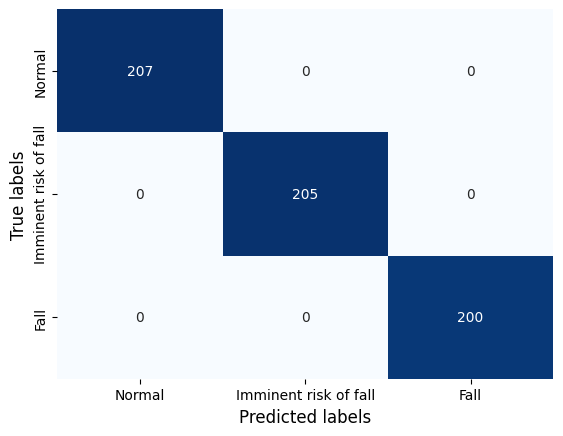

In [218]:
# Confusion matrix plot 
import seaborn as sns
class_names = ['Normal', 'Imminent risk of fall', 'Fall']
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, 
            annot = True, 
            fmt = 'd', 
            cmap = 'Blues', 
            cbar = False, 
            xticklabels = class_names, 
            yticklabels = class_names)

plt.xlabel("Predicted labels", fontsize = 12)
plt.ylabel("True labels", fontsize = 12)

plt.show()